In [1]:
import torch
import os
import sys
sys.path.insert(0, os.path.abspath('../../'))
from DNN_module import Net

# CPU
torch.set_default_device("cpu")

%run ../../NCoinDP_functions.ipynb

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch

# Number of data points
#S = 500

# time inteval

delta = 1/12

#n = int(S/delta)
n = 5000

# Observation time
obtime = np.arange(0,n+1)/n * n * delta
print(len(obtime))

5001


In [3]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
if torch.cuda.is_available(): 
 dev = "cuda:0" 
else: 
 dev = "cpu"
device = torch.device(dev)

2.1.2+cu121
True
NVIDIA A10


In [5]:
#L = 1500000

kappa_range = [0.6, 3.5]
beta_range = [0.5, 2]
sigma2_range = [0.1, 0.5]

lambda_range = [0.01, 1]
mu_range = [0.1,1.5]
output_range = np.array([kappa_range, beta_range, sigma2_range, lambda_range, mu_range])

In [6]:
# Data import
torch.set_default_device(device)

X_raw = []
output_raw = []
for j in [0, 1]:
    sim_path = "../../../depot_hyun/hyun/SQRJ/SQRJ_sim" + str(j) + "_" + str(n)+ ".pt"
    [tmp_X, tmp_y] = torch.load(sim_path)
    X_raw.append(tmp_X)
    output_raw.append(tmp_y)

X_raw = torch.cat(X_raw, dim = 0)
output = torch.cat(output_raw, dim = 0)
X_raw = X_raw.to("cpu")

c_tmp = torch.quantile(X_raw, torch.tensor([.0001,.9999], device = "cpu"), 0)
a = torch.reshape(c_tmp[0], (1, c_tmp.size()[1]))
b = torch.reshape(c_tmp[1], (1, c_tmp.size()[1]))

X = torch.clone((X_raw - a) / (b - a))

X = X.to(device)
output = output.to(device)

L = X.size()[0]
Lval = 40000
Ltest = 10000

X_train = X[range(0,L-Lval-Ltest),:]
y_train = output[range(0,L-Lval-Ltest),:]

X_val = X[range(L-Lval-Ltest,L-Ltest),:]
y_val = output[range(L-Lval-Ltest,L-Ltest),:]

X_test = X[range(L-Ltest,L),:]
y_test = output[range(L-Ltest,L),:]

print(X_train.size(), X_val.size(),X_test.size())

# Define the input and output dimensions
D_in, H, H2, H3, D_out = X_train.size()[1], 512, 512, 512, y_train.size()[1]

# Create an instance of the Net class with specified dimensions
torch.manual_seed(2725)

# import net
net = Net(D_in, D_out, H = H, H2 = H2, H3 = H3)
model_save_name = 'SQRJ_nets/SQRJ_infer' + '.pt'
path = F"./{model_save_name}"

torch.Size([450000, 71]) torch.Size([40000, 71]) torch.Size([10000, 71])


In [7]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
if torch.cuda.is_available(): 
 dev = "cuda:0" 
else: 
 dev = "cpu"
device = torch.device(dev)

2.1.2+cu121
True
NVIDIA A10


In [8]:
for i in range(X.size()[1]):
    print(i, torch.max(X[:,i]), a[0,i], b[0,i])

0 tensor(1.2435, device='cuda:0') tensor(0.5158) tensor(13.5969)
1 tensor(1.2432, device='cuda:0') tensor(0.5157) tensor(13.6017)
2 tensor(1.5086, device='cuda:0') tensor(0.0002) tensor(1.5566)
3 tensor(1.4951, device='cuda:0') tensor(0.0003) tensor(1.6491)
4 tensor(1.4950, device='cuda:0') tensor(0.0003) tensor(1.6490)
5 tensor(1.6315, device='cuda:0') tensor(0.1409) tensor(3.8528)
6 tensor(1.5173, device='cuda:0') tensor(1.0026) tensor(1.4872)
7 tensor(1.3067, device='cuda:0') tensor(0.0077) tensor(0.2289)
8 tensor(1.0832, device='cuda:0') tensor(-0.8417) tensor(2.3104)
9 tensor(2.0872, device='cuda:0') tensor(2.4860e-07) tensor(0.4626)
10 tensor(2.1219, device='cuda:0') tensor(2.2269e-07) tensor(0.4366)
11 tensor(2.7180, device='cuda:0') tensor(3.9181e-09) tensor(0.3144)
12 tensor(1., device='cuda:0') tensor(0.9986) tensor(0.9998)
13 tensor(1., device='cuda:0') tensor(0.9982) tensor(0.9998)
14 tensor(1., device='cuda:0') tensor(0.9976) tensor(0.9998)
15 tensor(1., device='cuda:0') t

In [9]:
import torch
import torch.optim as optim
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
# N is batch size; 
# D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
# L = 1000 -> H = 64

# Define the batch size
BATCH_SIZE = 64


# Use torch.utils.data to create a DataLoader 
# that will take care of creating batches 
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle=True, generator=torch.Generator(device=device))
dataset_size = len(dataloader.dataset)

In [10]:
def weighted_mse_loss(input, target, weight):
        return (weight * (input - target) ** 2).sum()
out_range = [torch.quantile(output,.01, 0).detach().cpu().numpy(), torch.quantile(output,.99, 0).detach().cpu().numpy()]
weight_1 = torch.tensor(1/(out_range[1] - out_range[0])**2)
print(weight_1)

tensor([0.1239, 0.4630, 6.5048, 1.0624, 0.5305], device='cuda:0')


In [26]:
learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-5)

train_error_plt = []
val_error_plt = []

torch.manual_seed(2000)
N_EPOCHS = 350
# Loop over epochs
for epoch in range(N_EPOCHS):
    for id_batch, (x_batch, y_batch) in enumerate(dataloader):
        y_batch_pred = net(x_batch)
        #loss = loss_fn(y_batch_pred, y_batch)
        loss = weighted_mse_loss(y_batch, y_batch_pred, weight_1)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 10 ==0 and id_batch % 1000 == 0:
            loss, current = loss.item(), (id_batch + 1)* len(x_batch)
            print(f"train_loss: {loss/BATCH_SIZE:>7f}  [{current:>5d}/{dataset_size:>5d}]")

    with torch.no_grad():
           net.eval()
           theta_pred_train = net(X_train)
           #train_loss = loss_fn(theta_pred_train,Y_train) / L_train
           train_loss = weighted_mse_loss(y_train, theta_pred_train, weight_1) /( L - Lval - Ltest )
           
           train_error_plt = np.append(train_error_plt, train_loss.to("cpu"))

           theta_pred_val = net(X_val)
           #val_loss = loss_fn(Y_val, theta_pred_val) / L_val
           val_loss = weighted_mse_loss(y_val, theta_pred_val, weight_1) / Lval
           
           val_error_plt = np.append(val_error_plt, val_loss.to("cpu"))

    if epoch % 10 ==0:
        print(f"Epoch {epoch + 1}\n-------------------------------")
        print(f"train_loss {train_loss:>7f} val_loss {val_loss:>7f}")
        #print("learning rate: ", learning_rate, ", sim: ", sim)

    ## Choose Best Model
    if val_error_plt[epoch] == np.min(val_error_plt):
         best=epoch
         torch.save(net.state_dict(), path)

    if epoch % 100 ==99:
        net.load_state_dict(torch.load(path))
        learning_rate = max(learning_rate * 1e-1, 1e-9)

train_loss: 3.431457  [   64/450000]
train_loss: 0.068000  [64064/450000]
train_loss: 0.046851  [128064/450000]
train_loss: 0.058165  [192064/450000]
train_loss: 0.047530  [256064/450000]
train_loss: 0.046943  [320064/450000]
train_loss: 0.031192  [384064/450000]
train_loss: 0.032122  [448064/450000]
Epoch 1
-------------------------------
train_loss 0.068588 val_loss 0.067784
train_loss: 0.010315  [   64/450000]
train_loss: 0.012974  [64064/450000]
train_loss: 0.015831  [128064/450000]
train_loss: 0.008977  [192064/450000]
train_loss: 0.015745  [256064/450000]
train_loss: 0.011194  [320064/450000]
train_loss: 0.016867  [384064/450000]
train_loss: 0.008484  [448064/450000]
Epoch 11
-------------------------------
train_loss 0.014041 val_loss 0.014196
train_loss: 0.012665  [   64/450000]
train_loss: 0.015630  [64064/450000]
train_loss: 0.013372  [128064/450000]
train_loss: 0.014680  [192064/450000]
train_loss: 0.010660  [256064/450000]
train_loss: 0.014647  [320064/450000]
train_loss: 0

train_loss: 0.009263  [320064/450000]
train_loss: 0.011456  [384064/450000]
train_loss: 0.011592  [448064/450000]
Epoch 211
-------------------------------
train_loss 0.011008 val_loss 0.012040
train_loss: 0.008209  [   64/450000]
train_loss: 0.010292  [64064/450000]
train_loss: 0.010326  [128064/450000]
train_loss: 0.012345  [192064/450000]
train_loss: 0.015414  [256064/450000]
train_loss: 0.006094  [320064/450000]
train_loss: 0.014781  [384064/450000]
train_loss: 0.016175  [448064/450000]
Epoch 221
-------------------------------
train_loss 0.011631 val_loss 0.012597
train_loss: 0.011467  [   64/450000]
train_loss: 0.009495  [64064/450000]
train_loss: 0.011871  [128064/450000]
train_loss: 0.011075  [192064/450000]
train_loss: 0.012149  [256064/450000]
train_loss: 0.014319  [320064/450000]
train_loss: 0.012391  [384064/450000]
train_loss: 0.013315  [448064/450000]
Epoch 231
-------------------------------
train_loss 0.010882 val_loss 0.012065
train_loss: 0.010686  [   64/450000]
train

In [27]:
print(np.min(val_error_plt))

0.011311392299830914


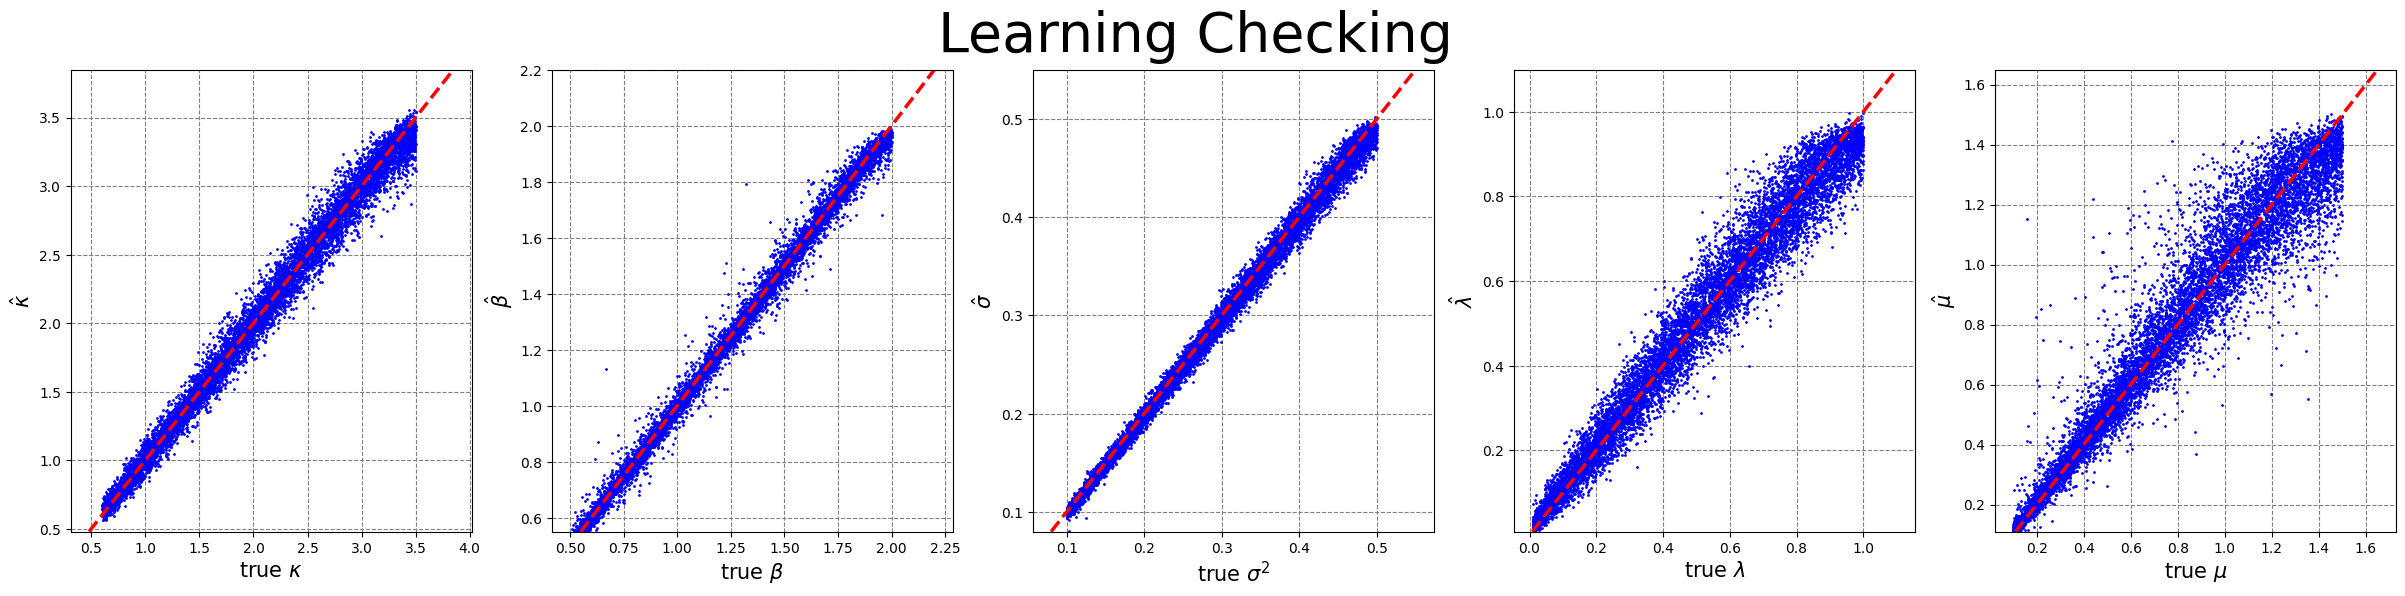

In [11]:
net.load_state_dict(torch.load(path))
net.eval()
torch.set_default_device("cpu")

net = net.to("cpu")
X_test = X_test.to("cpu")
y_test = y_test.to("cpu")

true_name = [r'true $\kappa$', r'true $\beta$', r'true $\sigma^2$', r'true $\lambda$', r'true $\mu$']
#true_name = [r'true $\kappa$', r'true $\beta$', r'true $\lambda$', r'true $\mu$']

esti_name = [r'$\hat{\kappa}$', r'$\hat{\beta}$', r'$\hat{\sigma}$', r'$\hat{\lambda}$', r'$\hat{\mu}$']
#esti_name = [r'$\hat{\kappa}$', r'$\hat{\beta}$', r'$\hat{\lambda}$', r'$\hat{\mu}$']


with torch.no_grad():
    net.eval()
    tmp1 = net(X_test)[:,0]
    tmp2 = net(X_test)[:,1]
    tmp3 = net(X_test)[:,2]
    tmp4 = net(X_test)[:,3]
    tmp5 = net(X_test)[:,4]

tmp = [tmp1.detach().cpu().numpy().tolist(),
       tmp2.detach().cpu().numpy().tolist(),
       tmp3.detach().cpu().numpy().tolist(),
       tmp4.detach().cpu().numpy().tolist(),
       tmp5.detach().cpu().numpy().tolist()]


## Plot for model checking
lim = [[kappa_range[0] * 0.8, kappa_range[1] * 1.1]
       ,[beta_range[0] * 1.1, beta_range[1] * 1.1]
       ,[sigma2_range[0] * 0.8, sigma2_range[1] * 1.1]
       ,[lambda_range[0] * 0.8, lambda_range[1] * 1.1]
       ,[mu_range[0] * 1.1, mu_range[1] * 1.1]]
#lim = [[kappa_range[0] * 0.8, kappa_range[1] * 1.1]
#       ,[beta_range[0] * 1.1, beta_range[1] * 1.1]
#       ,[lambda_range[0] * 0.8, lambda_range[1] * 1.1]
#       ,[mu_range[0] * 1.1, mu_range[1] * 1.1]]

fig, axes = plt.subplots(1, len(tmp), figsize=(30,6))
fig.suptitle('Learning Checking', fontsize = 40)

for i in range(len(tmp)):
    lim1 = lim[i]
    tmp1 = tmp[i]
    axes[i].scatter(y_test[:,i], tmp1, marker='o', color='b', s= 1)
    axes[i].set_xlabel(true_name[i], fontsize=15)
    axes[i].set_ylabel(esti_name[i], fontsize=15)
    axes[i].plot(np.linspace(lim1[0], lim1[1], 1000), np.linspace(lim1[0], lim1[1], 1000), color = "red", linestyle='dashed', linewidth = 2.5)
    axes[i].set_axisbelow(True)
    axes[i].grid(color='gray', linestyle='dashed')
    axes[i].set_ylim(lim1)

#fig.tight_layout()
#fig.savefig("JOU_plots/MROUJ.pdf") 

In [12]:
torch.set_default_device("cpu")
torch.manual_seed(2726)

param = torch.tensor([1, 1.6, 0.3, 0.07, 0.8]) 
param1 = torch.tensor([2, 0.8, 0.4, 0.5, 0.5]) 
param2 = torch.tensor([3, 1.3, 0.2, 0.8, 0.25]) 


sim_test = 1
y0 = torch.ones(sim_test)

torch.manual_seed(1)
    
yL = SQRJ_simul_sample(obtime, 20, y0, param[0]*torch.ones(sim_test), param[1]*torch.ones(sim_test), 
    param[2] ** (1/2)* torch.ones(sim_test), param[3]* torch.ones(sim_test), param[4]* torch.ones(sim_test))

x_test = SQRJ_summary(yL)

yL1 = SQRJ_simul_sample(obtime, 20, y0, param1[0]*torch.ones(sim_test), param1[1]*torch.ones(sim_test), 
    param1[2] ** (1/2)* torch.ones(sim_test), param1[3]* torch.ones(sim_test), param1[4]* torch.ones(sim_test))

x_test1 = SQRJ_summary(yL1)

yL2 = SQRJ_simul_sample(obtime, 20, y0, param2[0]*torch.ones(sim_test), param2[1]*torch.ones(sim_test), 
    param2[2] ** (1/2)* torch.ones(sim_test), param2[3]* torch.ones(sim_test), param2[4]* torch.ones(sim_test))

x_test2 = SQRJ_summary(yL2)


print(x_test.size())

torch.Size([1, 71])


In [13]:
x_test_scale = torch.clone((x_test - a ) / (b - a))
x_test1_scale = torch.clone((x_test1 - a ) / (b - a))
x_test2_scale = torch.clone((x_test2 - a ) / (b - a))

print(torch.mean(net(x_test_scale),0))
print(torch.mean(net(x_test1_scale),0))
print(torch.mean(net(x_test2_scale),0))


tensor([0.9919, 1.6385, 0.2877, 0.1014, 0.8912], grad_fn=<MeanBackward1>)
tensor([1.9992, 0.8142, 0.3895, 0.5133, 0.5050], grad_fn=<MeanBackward1>)
tensor([3.0689, 1.2770, 0.1972, 0.8577, 0.2759], grad_fn=<MeanBackward1>)


In [14]:
x0 = torch.reshape(x_test_scale, (1,x_test_scale.size()[1]))
x1 = torch.reshape(x_test1_scale, (1,x_test_scale.size()[1]))
x2 = torch.reshape(x_test2_scale, (1,x_test_scale.size()[1]))

In [15]:
net.load_state_dict(torch.load(path))
net = net.to("cpu")

In [16]:
path_cal = "../../../depot_hyun/hyun/SQRJ/SQRJ_sim"
    
X_cal = []
y_cal = []

sim_num = []
for j in range(2, 30):
    sim_num.append(j)

for j in sim_num:
    path_tmp = path_cal+str(j)+ "_" + str(n)+ ".pt"
    [tmp_X, tmp_y] = torch.load(path_tmp)
    X_cal.append(tmp_X)
    y_cal.append(tmp_y)

X_cal = torch.cat(X_cal, dim = 0)
y_cal = torch.cat(y_cal, dim = 0)

X_cal = torch.clone((X_cal - a) / (b - a))

In [37]:
results_00 = conf_inf_sd(x0, X_cal, y_cal, net, .03)
results_01 = conf_inf_sd(x0, X_cal, y_cal, net, .04)
results_02 = conf_inf_sd(x0, X_cal, y_cal, net, .05)
torch.save([results_00, results_01, results_02], "SQRJ_calibrate/SQRJ_infer_0.pt")

train_loss: 0.272892  [   64/73500]
train_loss: 0.248813  [ 6464/73500]
train_loss: 0.222238  [12864/73500]
train_loss: 0.202717  [19264/73500]
train_loss: 0.196838  [25664/73500]
train_loss: 0.203406  [32064/73500]
train_loss: 0.192381  [38464/73500]
train_loss: 0.178857  [44864/73500]
train_loss: 0.178642  [51264/73500]
train_loss: 0.153035  [57664/73500]
train_loss: 0.142540  [64064/73500]
train_loss: 0.154972  [70464/73500]
Epoch 1
-------------------------------
train_loss 0.137519 val_loss 0.139364
Epoch 31
-------------------------------
train_loss 0.023898 val_loss 0.025448
train_loss: 0.018977  [   64/73500]
train_loss: 0.023086  [ 6464/73500]
train_loss: 0.023347  [12864/73500]
train_loss: 0.022815  [19264/73500]
train_loss: 0.023997  [25664/73500]
train_loss: 0.025304  [32064/73500]
train_loss: 0.019711  [38464/73500]
train_loss: 0.022443  [44864/73500]
train_loss: 0.023141  [51264/73500]
train_loss: 0.021944  [57664/73500]
train_loss: 0.023246  [64064/73500]
train_loss: 0.0

Epoch 91
-------------------------------
train_loss 0.025601 val_loss 0.027044
train_loss: 0.027259  [   64/122499]
train_loss: 0.028622  [ 6464/122499]
train_loss: 0.024734  [12864/122499]
train_loss: 0.018439  [19264/122499]
train_loss: 0.030999  [25664/122499]
train_loss: 0.035799  [32064/122499]
train_loss: 0.027236  [38464/122499]
train_loss: 0.019321  [44864/122499]
train_loss: 0.025861  [51264/122499]
train_loss: 0.022589  [57664/122499]
train_loss: 0.022821  [64064/122499]
train_loss: 0.019692  [70464/122499]
train_loss: 0.019789  [76864/122499]
train_loss: 0.028699  [83264/122499]
train_loss: 0.025233  [89664/122499]
train_loss: 0.023623  [96064/122499]
train_loss: 0.024757  [102464/122499]
train_loss: 0.028225  [108864/122499]
train_loss: 0.028425  [115264/122499]
train_loss: 0.022855  [121664/122499]
Epoch 121
-------------------------------
train_loss 0.025305 val_loss 0.026979
train_loss: 0.022060  [   64/122499]
train_loss: 0.026814  [ 6464/122499]
train_loss: 0.027288  [

In [38]:
results_10 = conf_inf_sd(x1, X_cal, y_cal, net, .03)
results_11 = conf_inf_sd(x1, X_cal, y_cal, net, .04)
results_12 = conf_inf_sd(x1, X_cal, y_cal, net, .05)
torch.save([results_10, results_11, results_12], "SQRJ_calibrate/SQRJ_infer_1.pt")

train_loss: 0.530907  [   64/73500]
train_loss: 0.512077  [ 6464/73500]
train_loss: 0.467898  [12864/73500]
train_loss: 0.459800  [19264/73500]
train_loss: 0.446118  [25664/73500]
train_loss: 0.429350  [32064/73500]
train_loss: 0.394478  [38464/73500]
train_loss: 0.370217  [44864/73500]
train_loss: 0.349954  [51264/73500]
train_loss: 0.348757  [57664/73500]
train_loss: 0.326184  [64064/73500]
train_loss: 0.296211  [70464/73500]
Epoch 1
-------------------------------
train_loss 0.290810 val_loss 0.291742
Epoch 31
-------------------------------
train_loss 0.035639 val_loss 0.036613
train_loss: 0.032427  [   64/73500]
train_loss: 0.044377  [ 6464/73500]
train_loss: 0.034238  [12864/73500]
train_loss: 0.034337  [19264/73500]
train_loss: 0.032387  [25664/73500]
train_loss: 0.039535  [32064/73500]
train_loss: 0.035917  [38464/73500]
train_loss: 0.030477  [44864/73500]
train_loss: 0.034642  [51264/73500]
train_loss: 0.042815  [57664/73500]
train_loss: 0.037705  [64064/73500]
train_loss: 0.0

train_loss: 0.033939  [   64/122499]
train_loss: 0.033540  [ 6464/122499]
train_loss: 0.038501  [12864/122499]
train_loss: 0.034157  [19264/122499]
train_loss: 0.034874  [25664/122499]
train_loss: 0.036184  [32064/122499]
train_loss: 0.035939  [38464/122499]
train_loss: 0.034235  [44864/122499]
train_loss: 0.034922  [51264/122499]
train_loss: 0.027595  [57664/122499]
train_loss: 0.038341  [64064/122499]
train_loss: 0.030434  [70464/122499]
train_loss: 0.035590  [76864/122499]
train_loss: 0.031397  [83264/122499]
train_loss: 0.033685  [89664/122499]
train_loss: 0.031604  [96064/122499]
train_loss: 0.025799  [102464/122499]
train_loss: 0.027573  [108864/122499]
train_loss: 0.027117  [115264/122499]
train_loss: 0.043472  [121664/122499]
Epoch 121
-------------------------------
train_loss 0.031572 val_loss 0.033226
train_loss: 0.046173  [   64/122499]
train_loss: 0.033515  [ 6464/122499]
train_loss: 0.029384  [12864/122499]
train_loss: 0.043271  [19264/122499]
train_loss: 0.038661  [25664

In [ ]:
results_20 = conf_inf_sd(x2, X_cal, y_cal, net, .03)
results_21 = conf_inf_sd(x2, X_cal, y_cal, net, .04)
results_22 = conf_inf_sd(x2, X_cal, y_cal, net, .05)
torch.save([results_20, results_21, results_22], "SQRJ_calibrate/SQRJ_infer_2.pt")

train_loss: 0.577215  [   64/73500]
train_loss: 0.543916  [ 6464/73500]
train_loss: 0.505736  [12864/73500]
train_loss: 0.487660  [19264/73500]
train_loss: 0.490795  [25664/73500]
train_loss: 0.468481  [32064/73500]
train_loss: 0.402499  [38464/73500]
train_loss: 0.414499  [44864/73500]
train_loss: 0.358532  [51264/73500]
train_loss: 0.363288  [57664/73500]
train_loss: 0.346174  [64064/73500]
train_loss: 0.317625  [70464/73500]
Epoch 1
-------------------------------
train_loss 0.328961 val_loss 0.328198
Epoch 31
-------------------------------
train_loss 0.036446 val_loss 0.037038
train_loss: 0.031108  [   64/73500]
train_loss: 0.033558  [ 6464/73500]
train_loss: 0.047183  [12864/73500]
train_loss: 0.036503  [19264/73500]
train_loss: 0.043422  [25664/73500]
train_loss: 0.034207  [32064/73500]
train_loss: 0.041028  [38464/73500]
train_loss: 0.031369  [44864/73500]
train_loss: 0.036099  [51264/73500]
train_loss: 0.048852  [57664/73500]
train_loss: 0.035102  [64064/73500]
train_loss: 0.0

In [18]:
# Sampling
size = 30000

samples = []
for case in range(3):
    sam_0 = [] 
    tmp = torch.load("SQRJ_calibrate/SQRJ_infer_" +str(case) + ".pt")

    for r in range(3):
        sam_1 = [] # size 6 * size
        results = tmp[r]
        for j in range(results[1].size()[1]):
            random.seed(10)
            vec = results[1][:,j].detach().cpu().numpy()
            ind = ((vec<output_range[j][1]) & (vec>output_range[j][0]))
            vec = np.copy(vec[ind])
            
            weights = np.copy(results[0].detach().cpu().numpy())
            weights = np.copy(weights[ind])
            P = weights/weights.sum()

            sam_2 = np.random.choice(vec,size,replace=True, p=P)
            sam_1.append(sam_2) 
        sam_0.append(sam_1)
    samples.append(sam_0)

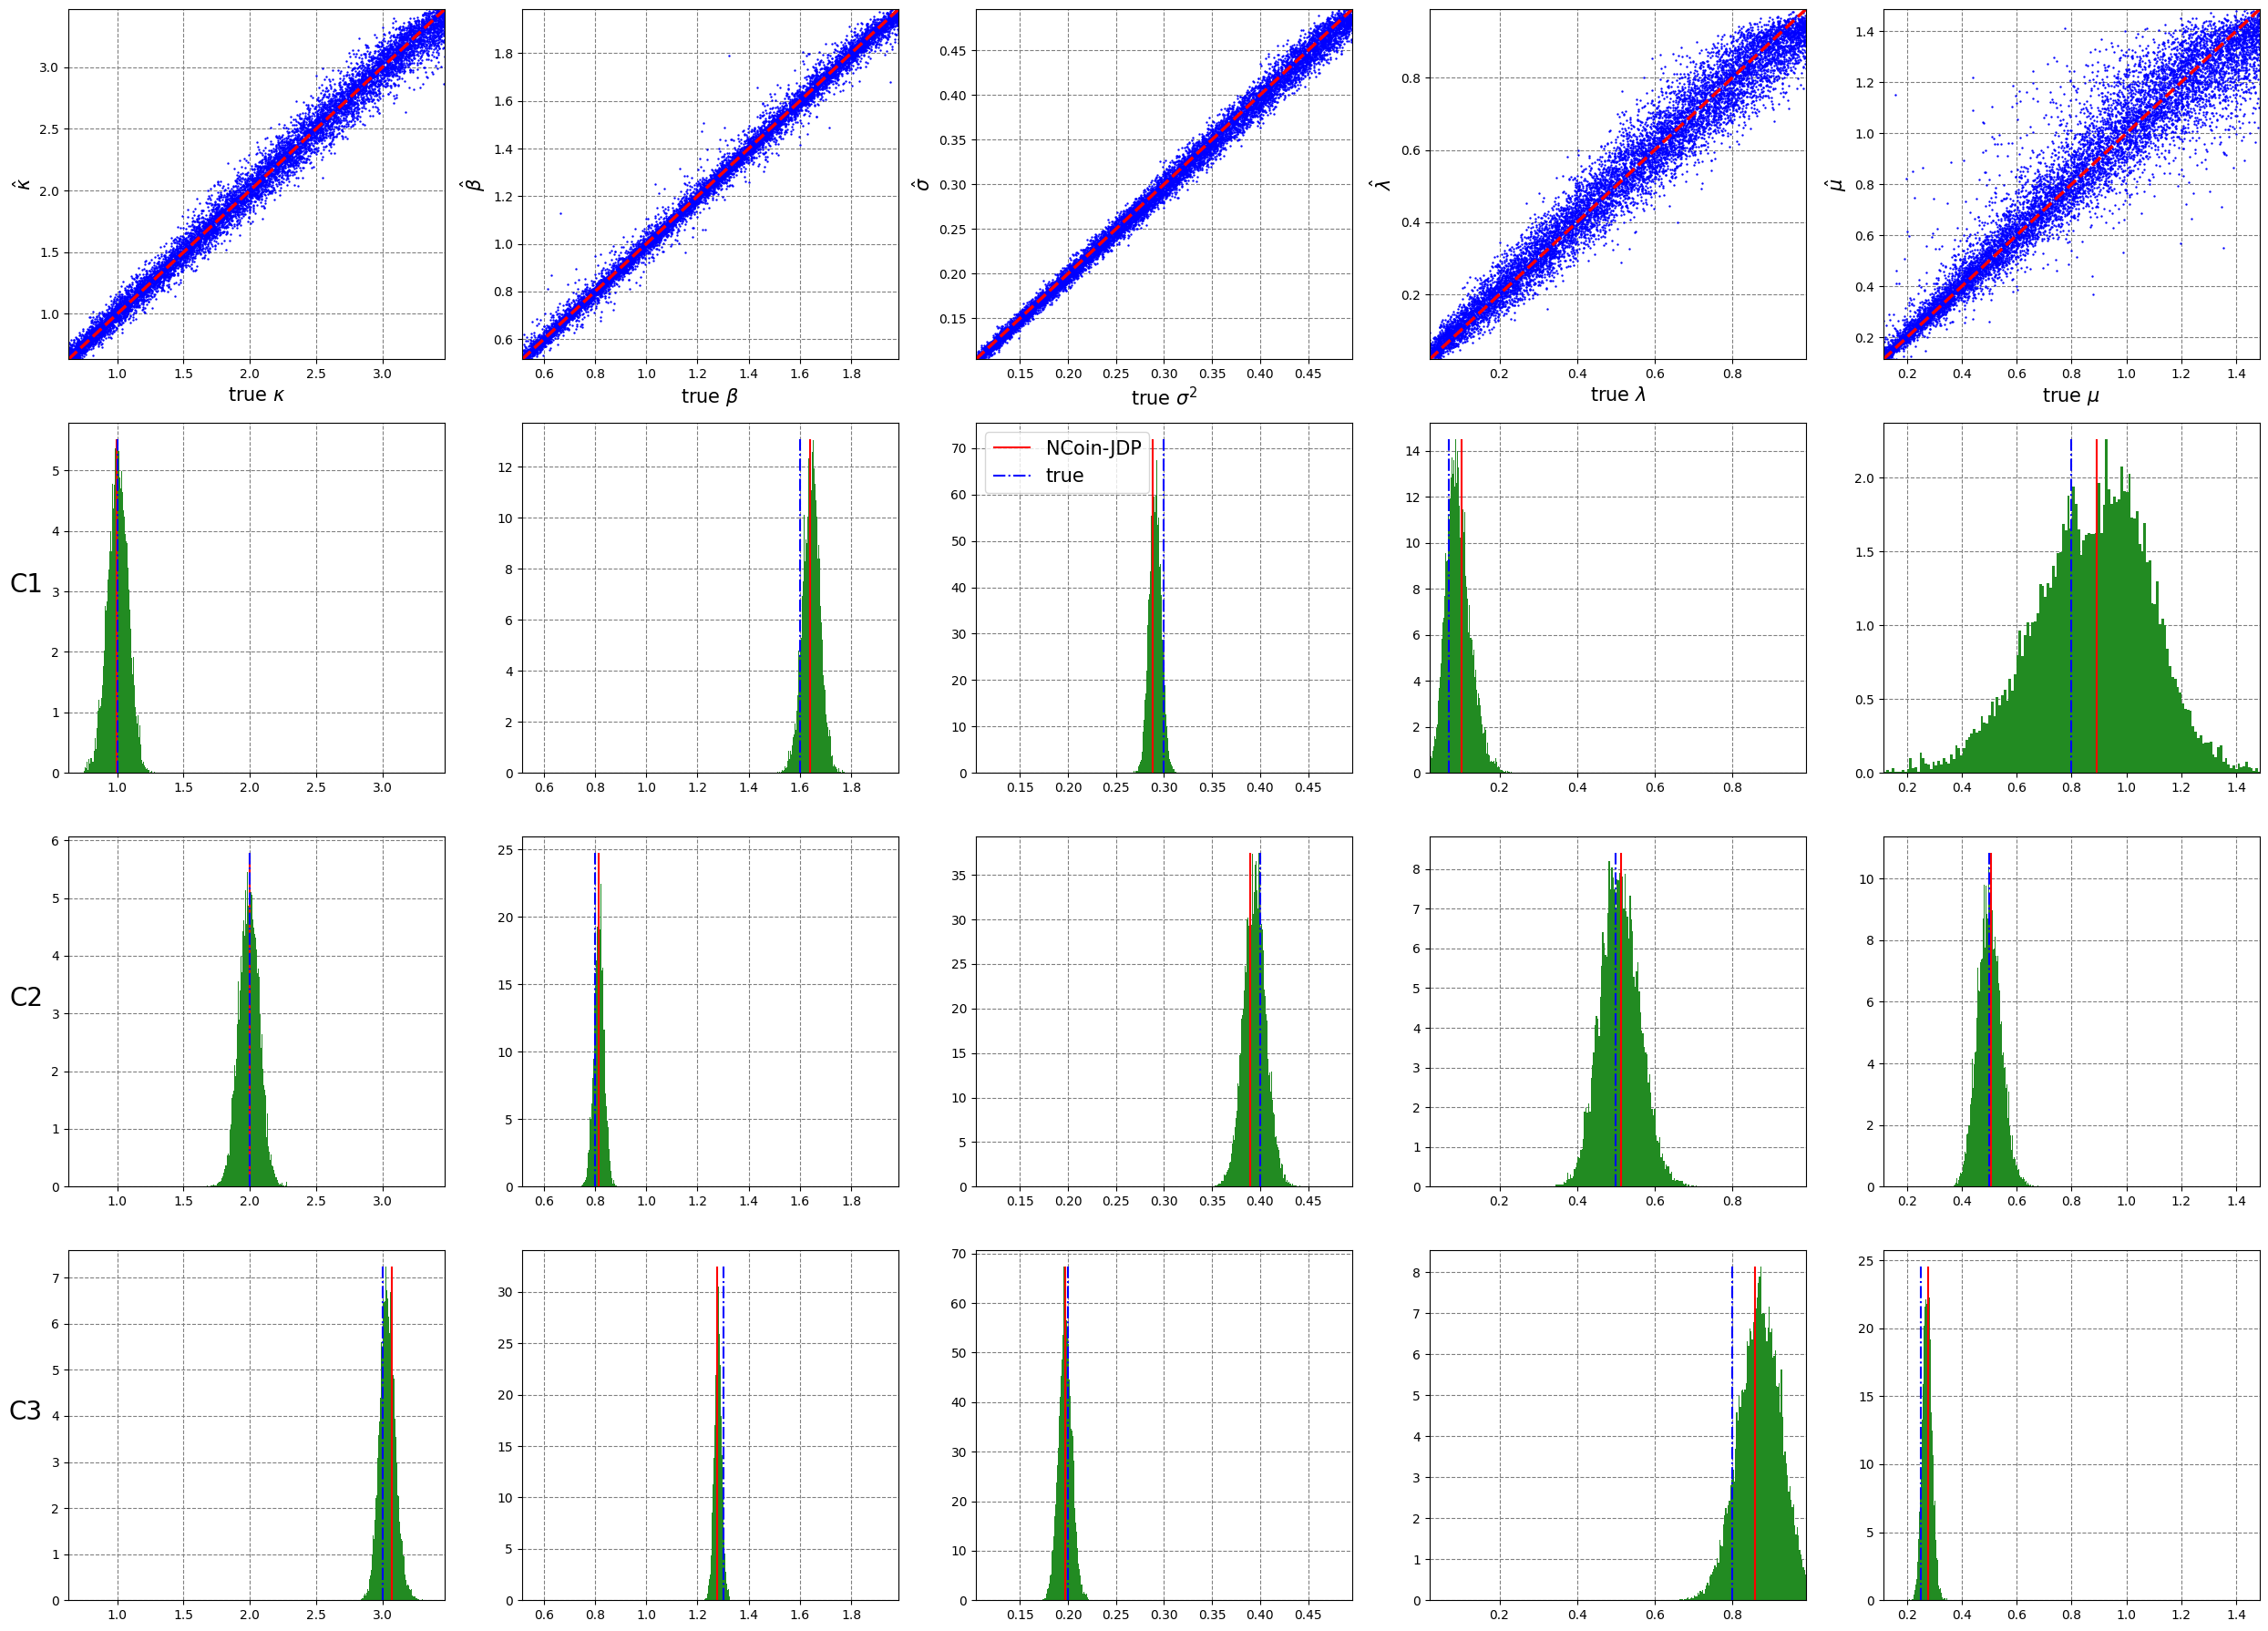

In [19]:
import matplotlib.pyplot as plt
true_name = [r'true $\kappa$', r'true $\beta$', r'true $\sigma^2$', r'true $\lambda$', r'true $\mu$']
#true_name = [r'true $\kappa$', r'true $\beta$', r'true $\lambda$', r'true $\mu$']

true_param = np.array(torch.stack([param,param1,param2]))

fig, axs = plt.subplots(4, len(true_name), figsize=(25,18))

est = [net(x0).detach()[0], net(x1).detach()[0], net(x2).detach()[0]]


with torch.no_grad():
    net.eval()
    tmp = net(X_test)
    tmp = tmp.detach().cpu().numpy()

## Plot for model checking

lim_left = torch.quantile(output,.01, 0).detach().cpu().numpy()
lim_right = torch.quantile(output,.99, 0).detach().cpu().numpy()


for i in range(len(tmp[0])):
    lim0 = lim_left[i]
    lim1 = lim_right[i]
    tmp1 = tmp[:, i]
    axs[0,i].scatter(y_test[:,i], tmp1, marker='o', color='b', s= 0.5)
    axs[0,i].set_xlabel(true_name[i], fontsize=15)
    axs[0,i].set_ylabel(esti_name[i], fontsize=15)
    axs[0,i].plot(np.linspace(lim0, lim1, 1000), np.linspace(lim0, lim1, 1000), color = "red", linestyle='dashed', linewidth = 2.5)
    axs[0,i].set_axisbelow(True)
    axs[0,i].grid(color='gray', linestyle='dashed')
    axs[0,i].set_ylim([lim0, lim1])
    axs[0,i].set_xlim([lim0, lim1])
    #axs[0,0].set_title("Learning Checking", fontsize = 10)

for j in range(3):
    samples_plot = samples[j]
    samples_plot = np.array(samples[j])
    samples_plot = np.concatenate(samples_plot, axis = 1)

    for i in range(len(true_name)):
        lim0 = lim_left[i]
        lim1 = lim_right[i]
        
        y, x, _ = axs[j+1,i].hist(samples_plot[i,:], density=True, bins = 150, color = "forestgreen")
        axs[j+1,i].set_axisbelow(True)
        axs[j+1,i].grid(color='gray', linestyle='dashed')
        axs[j+1,i].set_xlim([lim0, lim1])
    
        axs[j+1,i].vlines(est[j][i], 0, max(y), color = 'red')
        axs[j+1,i].vlines(true_param[j,i], 0, max(y), color = 'blue', linestyle ="dashdot")
        if i == 2 and j == 1:
            axs[j,i].legend(['NCoin-JDP', 'true'], loc = "upper left", fontsize=15) 
axs[1, 0].set_ylabel("C1", fontsize=20, rotation=0, labelpad=20)
axs[2, 0].set_ylabel("C2", fontsize=20, rotation=0, labelpad=20)
axs[3, 0].set_ylabel("C3", fontsize=20, rotation=0, labelpad=20)
fig.tight_layout()
fig.savefig("../JD_plots/SQRJ_infer.pdf") 

In [20]:
# Mean
# Mode
# MAD
# STD
# 95% credible intervals

post_mean = []
post_med = []
post_mode = []
post_mad = []
post_std = []
post_interval = []
for i in range(3): #3 cases
    samples_plot = samples[i]
    samples_plot = np.array(samples[i])
    samples_plot = np.concatenate(samples_plot, axis = 1)

    post_mean_1 = []
    post_med_1 = []
    post_mode_1 = []
    post_mad_1 = []
    post_std_1 = []
    post_interval_1 = []
    
    for j in range(len(true_name)):
        tmp = samples_plot[j,:]
        np.random.seed(1)
        hpd_source = hpd_grid(tmp, 0.1, 5)
        
        post_mean_1.append(np.mean(tmp)) # mean
        post_med_1.append(np.median(tmp)) # mean
        post_mode_1.append(hpd_source[3][0]) # mode
        post_mad_1.append(mad_np(tmp)) # mad
        post_std_1.append(np.std(tmp))
        post_interval_1.append(np.array(hpd_source[0][0])) # interval
    
    post_mean.append(post_mean_1)
    post_med.append(post_med_1)
    post_mode.append(post_mode_1)
    post_mad.append(post_mad_1)
    post_std.append(post_std_1)
    post_interval.append(post_interval_1)

/tmp/ipykernel_14585/1091780546.py:30: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  density = kde.gaussian_kde(sample)


In [21]:
for i in range(3):
    print("Posterior mean C" + str(i), np.round(post_mean[i], 3))
    print("Posterior median C" + str(i), np.round(post_med[i], 3))
    print("Posterior mode C" + str(i), np.round(post_mode[i],3))
    print("Posterior mad  C" + str(i), np.round(post_mad[i],3))
    print("Posterior std  C" + str(i), np.round(post_std[i],3))
    print("Posterior intvl C" + str(i), np.round(post_interval[i],3))
    print("===========================================================================")
    
    
    
    
    

Posterior mean C0 [1.004 1.645 0.291 0.094 0.876]
Posterior median C0 [1.004 1.646 0.291 0.091 0.893]
Posterior mode C0 [1.009 1.652 0.292 0.09  0.985]
Posterior mad  C0 [0.052 0.023 0.004 0.021 0.143]
Posterior std  C0 [0.077 0.034 0.006 0.032 0.21 ]
Posterior intvl C0 [[0.875 1.131]
 [1.589 1.701]
 [0.281 0.301]
 [0.043 0.147]
 [0.529 1.213]]
Posterior mean C1 [1.994 0.816 0.394 0.511 0.501]
Posterior median C1 [1.994 0.816 0.395 0.51  0.5  ]
Posterior mode C1 [1.996 0.816 0.395 0.512 0.501]
Posterior mad  C1 [0.052 0.013 0.008 0.034 0.029]
Posterior std  C1 [0.078 0.02  0.012 0.051 0.043]
Posterior intvl C1 [[1.865 2.118]
 [0.784 0.848]
 [0.375 0.414]
 [0.428 0.594]
 [0.43  0.572]]
Posterior mean C2 [3.039 1.28  0.197 0.87  0.274]
Posterior median C2 [3.036 1.28  0.197 0.871 0.273]
Posterior mode C2 [3.028 1.281 0.196 0.87  0.27 ]
Posterior mad  C2 [0.039 0.009 0.005 0.037 0.012]
Posterior std  C2 [0.06  0.014 0.007 0.054 0.018]
Posterior intvl C2 [[2.938 3.136]
 [1.256 1.304]
 [0.1